### Exercise 7.05: Implementing the DCGAN
In this exercise, we will build and train the DCGAN on the MNIST dataset. We will use the MNIST dataset as the real data distribution. We will then generate fake data from a random distribution. After that, we will train the GAN to generate data that is similar to the MNIST dataset's.

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to generate real data samples
def realData(batch):
    # Get MNIST data
    (X_train, _), (_, _) = mnist.load_data()
    # Reshaping the input data to include channel
    X = X_train[:,:,:,np.newaxis]
    # Normalizing the data
    X = (X.astype('float32') - 127.5)/127.5
    # Generating a batch of data
    imageBatch = X[np.random.randint(0, X.shape[0], size=batch)] # np.random.randint(start,end,number-of-samples-to-generate)
    return imageBatch

In [3]:
# Generating a batch of images
mnistData = realData(25)

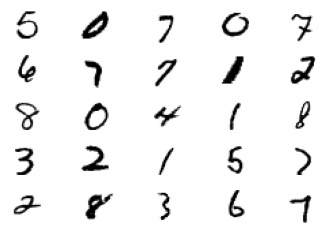

In [4]:
# Plotting the image
for j in range(5*5):
    pyplot.subplot(5,5,j+1)
    # Turn off axis
    pyplot.axis('off')
    pyplot.imshow(mnistData[j,:,:,0], cmap='gray_r')

In [5]:
# Function to generate inputs for generator function
def fakeInputs(batch, infeats):
    # Generate random noise data with shape (batch, input features)
    x_fake = np.random.uniform(-1, 1, size=[batch,infeats])
    return x_fake

In [6]:
# Function for the generator model
def genModel(infeats):
    # Defining the Generator model
    Genmodel = Sequential()
    Genmodel.add(Dense(512,input_dim=infeats))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Second layer of FC => RElu => BN layers
    Genmodel.add(Dense(7*7*64))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Upsample to 14 x 14
    Genmodel.add(Reshape((7,7,64)))
    Genmodel.add(Conv2DTranspose(32,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Upsample to 28 x 28
    Genmodel.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('tanh'))
    return Genmodel

In [7]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel,batch,infeats):
    # Generate inputs to the model
    genInputs = fakeInputs(batch,infeats)
    # Use inputs inside generator model to generate fake distribution
    X_fake = Genmodel.predict(genInputs)
    return X_fake

In [8]:
# Define the arguments like batch size and input feature
batch = 128
infeats = 100
Genmodel = genModel(infeats)
Genmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3136)              1608768   
                                                                 
 activation_1 (Activation)   (None, 3136)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 3136)             12544     
 hNormalization)                                        

2022-07-30 06:04:19.452892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Generating a fake sample and printing the shape
fake = fakedataGenerator(Genmodel, batch, infeats)
fake.shape

(128, 28, 28, 1)

Text(0.5, 0, 'Fake Sample Image')

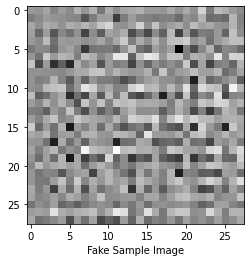

In [10]:
# Plotting the fake sample
plt.imshow(fake[1, :, :, 0], cmap='gray_r')
plt.xlabel('Fake Sample Image')

In [13]:
# Descriminator model as a function
def discModel():
    Discmodel = Sequential()
    Discmodel.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
    Discmodel.add(LeakyReLU(0.2))
    # Second layer of convolutions
    Discmodel.add(Conv2D(64,kernel_size=(5,5),strides=(2,2),padding='same'))
    Discmodel.add(LeakyReLU(0.2))
    # Fully connected layers
    Discmodel.add(Flatten())
    Discmodel.add(Dense(512))
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dense(1,activation='sigmoid'))
    Discmodel.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.002,beta_1=0.5),metrics=['accuracy'])
    return Discmodel

In [14]:
# Print the summary of the discriminator model
Discmodel = discModel()
Discmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1606144   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)              

In [15]:
# Define the combined generator and discriminator model for updating the generator
def ganModel(Genmodel, Discmodel):
    # Discriminator cannot be trained
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # Adding the generator model
    Ganmodel.add(Genmodel)
    # Adding the discriminator without training the parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimize the Generator model
    Ganmodel.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5))
    return Ganmodel

In [16]:
# Initialize the gan model
gan_model = ganModel(Genmodel, Discmodel)
# Print summary of Gan model
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


In [17]:
# Defining the number of epochs
nEpochs = 5000

In [18]:
# Train the GAN network
for i in range(nEpochs):
    # Generate samples equal to the batch size from the real distribution
    x_real = realData(batch)
    # Generate fake samples using the fake data generator function
    x_fake = fakedataGenerator(Genmodel, batch, infeats)
    # Concatenating the real and fake data
    X = np.concatenate([x_real, x_fake])
    # Creating the dependent variable and initializing them as '0'
    Y = np.zeros(batch * 2)
    # Making the first set equal to batch with labels 1
    Y[:batch] = 1
    # Train the discriminator on the real samples
    discLoss = Discmodel.train_on_batch(X, Y)
    # Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch*2, infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch*2, 1))
    # Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 10 epochs
    if (i) % 50 == 0:
        # Printing the discriminator loss and accuracy
        x_real_test = realData(10)
        x_fake_test = fakedataGenerator(Genmodel, 10, infeats)
        # Concatenating the real and fake data
        X_test = np.concatenate([x_real_test, x_fake_test])
        # Creating the dependent variable and initializing them as '0'
        Y = np.zeros(20 * 2)
        Y[:10] = 1
        # Predicting probabilities
        preds = Discmodel.predict(X_test)
        print('Discriminator probability:{D}'.format(D=np.mean(preds)))
        # Generate fake samples using fake data generator function
        x_fake = fakedataGenerator(Genmodel, batch, infeats)
        # Saving the plots
        for j in range(5*5):
            pyplot.subplot(5,5,j+1)
            # Turn off axis
            pyplot.axis('off')
            pyplot.imshow(x_fake[j, :, :, 0], cmap='gray_r')
        filename = 'handwritten/GAN_MNIST_TRAINING_Plot%03d.png' % (i)
        pyplot.savefig(filename)
        pyplot.close()

Discriminator probability:0.7588812708854675
Discriminator probability:0.5001280307769775
Discriminator probability:0.47493380308151245
Discriminator probability:0.60723876953125
Discriminator probability:0.179430291056633
Discriminator probability:0.6111571788787842
Discriminator probability:0.20844106376171112
Discriminator probability:0.6395644545555115
Discriminator probability:0.5497204065322876
Discriminator probability:0.4566718637943268
Discriminator probability:0.5803000330924988
Discriminator probability:0.5473393201828003
Discriminator probability:0.5984452962875366
Discriminator probability:0.425868421792984
Discriminator probability:0.4341066777706146
Discriminator probability:0.2977079153060913
Discriminator probability:0.48915424942970276
Discriminator probability:0.4869467318058014
Discriminator probability:0.5756298303604126
Discriminator probability:0.47996848821640015
Discriminator probability:0.5743053555488586
Discriminator probability:0.3445327877998352
Discrimina

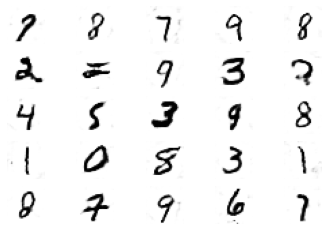

In [21]:
# Images predicted after training
x_fake = fakedataGenerator(Genmodel, 25, infeats)
# Visualizing the plots
for j in range(5*5):
    pyplot.subplot(5,5,j+1)
    # Turn off axis
    pyplot.axis('off')
    pyplot.imshow(x_fake[j, :, :, 0], cmap='gray_r')